In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Part 1: Trading Strategy

### 1.1: Dissecting Time

We start off by using "Algorithm 1: Intrinsic Event" [1] to dissect a time-series into Directional Change Intrinsic Time. This is done by having our new version of time defined by the movement, up or down, of the Price by some threshold (or delta).


**Implementation:**
This was first implemented on 1 Minute bars data while getting a feel of how to approach the coursework. This just dissects closing bid prices; the strategies later are implemented on tick data making use of bids and quotes.

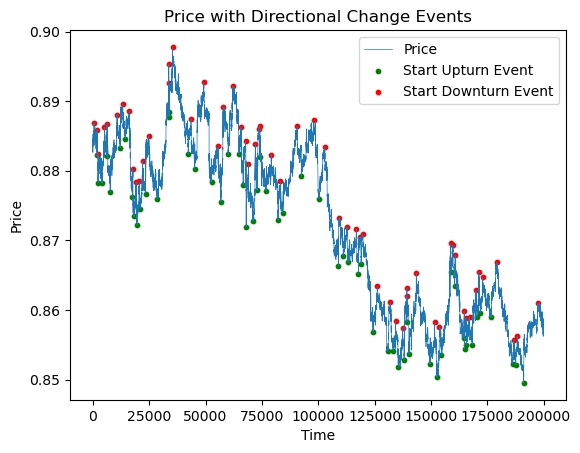

In [5]:
# Reading 1 Minute bar data
data = pd.read_csv("DAT_MT_EURGBP_M1_2023.csv")

# Column names as per data description
column_names = ['Date Stamp', 'Time Stamp', 'Bar OPEN Bid Quote', 'Bar HIGH Bid Quote', 'Bar LOW Bid Quote', 'Bar CLOSE Bid Quote', 'Volume']

# Assign column names to the DataFrame
data.columns = column_names

# Putting data into DataFrame
p = pd.DataFrame({"Price": data['Bar CLOSE Bid Quote']})


"""
 
                Intrinsic Time    /    Directional Change  algorithm from slide 44

                Here we just plot the prices and the points at which we detect direction changes

"""

# Initlaise variables for algo

# Defining events
p["Event"] = ''

# An initial event
run = "upward"       

# The ext(reme) values
ph = p['Price'][0]   
pl = ph              
pl_i = ph_i = 0

# delta (or threshold)
d=0.004                

# Slide 44 algorithm:
for t in range(0, len(p)):
        pt = p["Price"][t]
        if run == "downward":
            if pt < pl:
                pl = pt
                pl_i = t
            if pt >= pl * (1 + d):
                p.at[pl_i, 'Event'] = "start upturn event"
                run = "upward"
                ph = pt
                ph_i = t
                
                # Print for testing purposes
                # print(">> {} - Upward! : {}%, value {}".format(pl_i, round((pt - pl)/pl, 10), round(pt - pl,10)))
        elif run == "upward":
            if pt > ph:
                ph = pt
                ph_i = t
            if pt <= ph * (1 - d):
                p.at[ph_i, 'Event'] = "start downturn event"
                run = "downward"
                pl = pt
                pl_i = t
                
                # Print for testing purposes
                # print(">> {} - Downward! : {}%, value {}".format(ph_i, round((ph - pt)/ph, 10), round(ph - pt,10)))



"""

                Graphing Direction Changes
                
                Here we just plot the prices and the points at which we detect direction changes

"""

# Range for plot
range_bottom=1
range_top=200000

# Plotting price column
plt.plot(p.index[range_bottom:range_top+1], p['Price'].iloc[range_bottom:range_top+1], label='Price', linewidth=0.5)

# Gathering and Plotting events
upturn_events = p[(p['Event'] == 'start upturn event') & (p.index >= range_bottom) & (p.index <= range_top)]
downturn_events = p[(p['Event'] == 'start downturn event') & (p.index >= range_bottom) & (p.index <= range_top)]

plt.scatter(upturn_events.index, upturn_events['Price'], color='green', label='Start Upturn Event', s=10)
plt.scatter(downturn_events.index, downturn_events['Price'], color='red', label='Start Downturn Event', s=10)


# Adding labels, legend, and plotting
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Price with Directional Change Events")

plt.legend()

plt.show()

Each Event is shown by either a green or red dot for an Upturn or Downturn event. We can see some overshoot events where the price keeps going past the threshold delta.


### 1.2: Cleaning data

Based on the data provided, in the file status report, there are some gaps. We will simply get rid of these; we don't compute our directional changes and don't trade during these times.



In [13]:
import pandas as pd


# Data TO BE CLEANED
need_cleaning = "DAT_ASCII_EURCZK_T_202305.csv"
# Acompanying File Status Report
report = "DAT_ASCII_EURCZK_T_202305.txt"
# Cleaned Name
cleaned = "clean_DAT_ASCII_EURCZK_T_202305.csv"

                                                
#                              Manipulate the above variables to clean and store desired files 
##############################################################################################################################


# Read the file status report file
with open(report, "r") as file:
    status_report = file.readlines()

# Get the intervals by splitting the text
gaps = []
for line in status_report:
    if line.startswith("Gap of"):
        start_time = line.split("between ")[1].split(" and ")[0].strip()
        end_time = line.split(" and ")[1].split(".")[0].strip()
        gaps.append((start_time, end_time))



# Load csv - TO be CLEANED
data = pd.read_csv(need_cleaning, header=None)
data.columns = ['DateTime Stamp', 'Bid Quote', 'Ask Quote', 'Volume']


# Convert 'DateTime Stamp' to datetime format
data['DateTime Stamp'] = pd.to_datetime(data['DateTime Stamp'], format='%Y%m%d %H%M%S%f')

# Filter out the rows falling within the specified intervals from the gaps found
for start, end in gaps:
    start_date = start[:8]
    start_time = start[8:14]
    end_date = end[:8]
    end_time = end[8:14]

    start_str = f"{start_date} {start_time}"
    end_str = f"{end_date} {end_time}"

    start_datetime = pd.to_datetime(start_str, format='%Y%m%d %H%M%S')
    end_datetime = pd.to_datetime(end_str, format='%Y%m%d %H%M%S')

    data = data[(data['DateTime Stamp'] < start_datetime) | (data['DateTime Stamp'] > end_datetime)]


# Save the filtered data to a new CSV file
data.to_csv(cleaned, index=False)


### 1.3 Trading Strategy – Lab 8

The first strategy is that of Lab 8:

1. Open long position at $DC↑(θ)$ confirmation
2. (Take profit:) Close position at $ P_C \geq P_{DCC}↑\times  (1 + (\frac{\theta}{2})$
3. (Stop loss:) Close position at $ P_C \leq P_{DCC}↓\times  (1 - (\frac{\theta}{2})) $

We take a long position after the algorithm finds a directional change, and we exit out after the price rises or falls to the thresholds defined above, making a profit or loss respectively.

### Implementation:

Here we are dealing with tick data that contains bid and ask prices. We perform our directional change algorithm on mid-prices, $(\frac{P_{bid}+P_{ask}}{2})$, finding the events at which the price changes direction. After detecting an upward change, we execute the strategy on the available quote, i.e., opening a long position, on ask prices – as this is what we are able to buy from the market. As described above we then close the position.


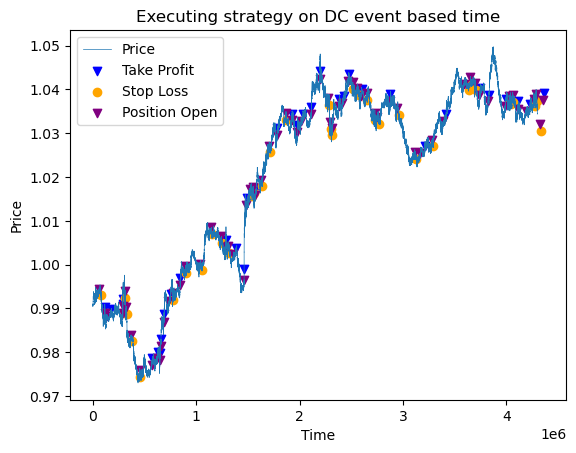

Final Profit/Loss: 0.000720000000000165


In [4]:


def strategy_1_point_3(data, print_true=True, delta=0.003):
    
    # Extract column names
    column_names = ['DateTime Stamp', 'Bid Quote', 'Ask Quote', 'Volume']
    
    # Assign column names to the DataFrame
    data.columns = column_names
    
    # Mid-price
    p = pd.DataFrame({"Price": (data['Bid Quote'] + data['Ask Quote']) / 2})         

    # Initialise ask quotes which we execute on:
    p["Ask Quote"] = data["Ask Quote"]

    # Initlaise variables for algo

    # Defining events
    p["Event"] = ''

    # Defining extreme times
    run = "upward"       
    ph = p['Price'][0]   
    pl = ph              
    pl_i = ph_i = 0

    # delta (or threshold)
    d = delta

    # Define theta value for profit and stop-loss
    theta = d

    # Initialise variables for tracking positions and profit/loss
    position_open = False
    entry_price = 0
    take_profit = 0
    stop_loss = 0
    profit_loss_list = []

    # For graphing
    take_profit_positions = []
    stop_loss_positions = []

    # Initialise lists to store positions opened
    position_open_t = []
    position_open_prices = []

    # Slide 44 algorithm:
    for t in range(0, len(p)):
        pt = p["Price"][t]
        pt_ask = p["Ask Quote"][t]

        if run == "downward":
            if pt < pl:
                pl = pt
                pl_i = t
            if pt >= pl * (1 + d):
                p.at[pl_i, 'Event'] = "start upturn event"
                run = "upward"
                ph = pt
                ph_i = t
                if not position_open:
                    entry_price = pt_ask
                    take_profit = entry_price * (1 + theta / 2)
                    stop_loss = entry_price * (1 - theta / 2)
                    position_open = True

                    # Store timestamp and price when position is opened
                    position_open_t.append(t)
                    position_open_prices.append(pt_ask)

        elif run == "upward":
            if pt > ph:
                ph = pt
                ph_i = t

            if position_open:
                if pt_ask >= take_profit or pt_ask <= stop_loss:
                    position_open = False
                    
                    if pt_ask >= take_profit:
                        profit_loss = pt_ask - entry_price
                        
                        # Store timestamp and price when take profit is triggered
                        take_profit_positions.append((t, pt_ask))  
                    else:
                        profit_loss = pt_ask - entry_price
                        
                        # Store timestamp and price when stop loss is triggered
                        stop_loss_positions.append((t, pt_ask))  
                    profit_loss_list.append(profit_loss)

            if pt <= ph * (1 - d):
                p.at[ph_i, 'Event'] = "start downturn event"
                run = "downward"
                pl = pt
                pl_i = t

    range_bottom = 1
    range_top = 4300000
    
    if print_true:
        # Plotting mid price (named 'Price') we dissect on
        plt.plot(p.index[range_bottom:range_top+1], p['Price'].iloc[range_bottom:range_top+1], label='Price', linewidth=0.5)

        # Plot Take Profit and Stop Loss points
        take_profit_t, take_profit_prices = zip(*take_profit_positions)
        stop_loss_t, stop_loss_prices = zip(*stop_loss_positions)
        plt.scatter(take_profit_t, take_profit_prices, color='blue', marker='v', label='Take Profit')
        plt.scatter(stop_loss_t, stop_loss_prices, color='orange', label='Stop Loss')

        plt.scatter(position_open_t, position_open_prices, color='purple', marker='v', label='Position Open')

        plt.xlabel("Time")
        plt.ylabel("Price")
        plt.title("Executing strategy on DC event based time")
        plt.legend()
        plt.show()

    # Calculate final profit/loss
    final_profit_loss = sum(profit_loss_list)
    print("Final Profit/Loss:", final_profit_loss)


data = pd.read_csv("clean_DAT_ASCII_EURUSD_T_202211.csv")
strategy_1_point_3(data, print_true=True, delta=0.003)

We have modified the original, slide 44, algorithm to incorporate the trading strategy in Lab 8. We can see where each position is opened, after finding a DC upturn event, and either closing the position in a loss or profit.





### 1.4: Trading Strategy - Lab 8 Modified

Let's now modify the strategy as follows:

1. Open long position at $DC↑(\theta)$ confirmation
2. (Take profit:) Close position at $P_C \geq P_{DCC}↑ \times (1+\frac{\theta}{2})$
3. (Stop loss:) Close position at $P_C \leq P_{DCC}↓ \times (1-\frac{\theta}{2})$
4. Open short position at DC↓$(\theta)$ confirmation
5. (Take profit:) Close position at $P_C \leq P_{DCC}↓ \times (1-\frac{\theta}{2})$
6. (Stop loss:) Close position at $P_C \geq P_{DCC}↑ \times (1+\frac{\theta}{2})$

Now we also open a short position in the same way, but defined in the opposite direction.


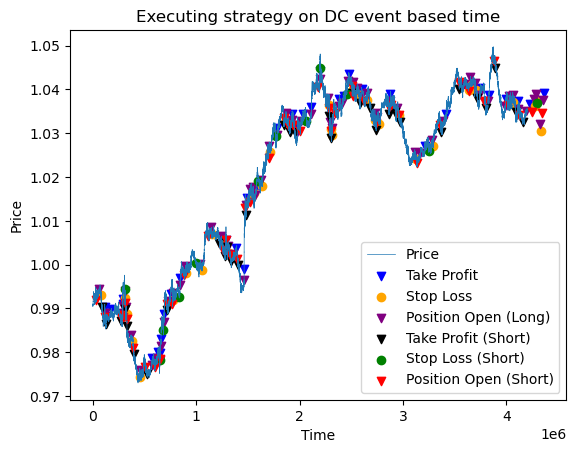

Final Profit/Loss: 0.007960000000000633


In [9]:
import pandas as pd
import matplotlib.pyplot as plt



def strategy_1_point_4(data, print_true=True, delta=0.003):
    # Extract column names
    column_names = ['DateTime Stamp', 'Bid Quote', 'Ask Quote', 'Volume']
    
    # Assign column names to the DataFrame
    data.columns = column_names
    
    # Mid-price
    p = pd.DataFrame({"Price": (data['Bid Quote'] + data['Ask Quote']) / 2})         

    # Initialise ask quotes which we execute on:
    p["Ask Quote"] = data["Ask Quote"]

    # Initialise variables for algo
    p["Event"] = ''

    run = "upward"       # initial run
    ph = p['Price'][0]   # highest price
    pl = ph              # lowest price
    pl_i = ph_i = 0
    d = delta

    # Define theta value for profit and stop-loss
    theta = d

    # Initialise variables for tracking positions and profit/loss
    position_open_long = False
    position_open_short = False
    entry_price = 0
    take_profit = 0
    stop_loss = 0
    profit_loss_list = []
    profit_loss_list_short = []

    # For graphing
    take_profit_positions = []
    stop_loss_positions = []
    take_profit_positions_short = []
    stop_loss_positions_short = []

    # Initialise lists to store positions opened
    position_open_long_t = []
    position_open_long_prices = []
    position_open_short_t = []
    position_open_short_prices = []

    # Slide 44 algorithm:
    for t in range(0, len(p)):
        pt = p["Price"][t]
        pt_ask = p["Ask Quote"][t]

        if run == "downward":
            if pt < pl:
                pl = pt
                pl_i = t

                # SHORTING
                if position_open_short:
                    if pt_ask <= take_profit_short or pt_ask >= stop_loss_short:
                        position_open_short = False
                        if pt_ask <= take_profit_short:
                            profit_loss = entry_price_short - pt_ask
                            take_profit_positions_short.append((t, pt_ask))
                        else:
                            profit_loss = entry_price_short - pt_ask
                            stop_loss_positions_short.append((t, pt_ask))
                        profit_loss_list_short.append(profit_loss)

            if pt >= pl * (1 + d):
                p.at[pl_i, 'Event'] = "start upturn event"
                run = "upward"
                ph = pt
                ph_i = t
                if not position_open_long:
                    entry_price = pt_ask
                    take_profit = entry_price * (1 + theta / 2)
                    stop_loss = entry_price * (1 - theta / 2)
                    position_open_long = True
                    position_open_long_t.append(t)
                    position_open_long_prices.append(pt_ask)

        elif run == "upward":
            if pt > ph:
                ph = pt
                ph_i = t

            if position_open_long:
                if pt_ask >= take_profit or pt_ask <= stop_loss:
                    position_open_long = False
                    if pt_ask >= take_profit:
                        profit_loss = pt_ask - entry_price
                        take_profit_positions.append((t, pt_ask))
                    else:
                        profit_loss = pt_ask - entry_price
                        stop_loss_positions.append((t, pt_ask))
                    profit_loss_list.append(profit_loss)

            if pt <= ph * (1 - d):
                p.at[ph_i, 'Event'] = "start downturn event"
                run = "downward"
                pl = pt
                pl_i = t

                # SHORTING
                if not position_open_short:
                    entry_price_short = pt_ask
                    take_profit_short = entry_price_short * (1 - theta / 2)
                    stop_loss_short = entry_price_short * (1 + theta / 2)
                    position_open_short = True
                    position_open_short_t.append(t)
                    position_open_short_prices.append(pt_ask)

    range_bottom = 1
    range_top = 4200000
    
    if print_true:
        
        # Plotting Price with Directional Change Events
        plt.plot(p.index[range_bottom:range_top+1], p['Price'].iloc[range_bottom:range_top+1], label='Price', linewidth=0.5)

        # Plot Take Profit and Stop Loss points --- Long
        take_profit_t, take_profit_prices = zip(*take_profit_positions)
        stop_loss_t, stop_loss_prices = zip(*stop_loss_positions)
        plt.scatter(take_profit_t, take_profit_prices, color='blue', marker='v', label='Take Profit')
        plt.scatter(stop_loss_t, stop_loss_prices, color='orange', label='Stop Loss')
        plt.scatter(position_open_long_t, position_open_long_prices, color='purple', marker='v', label='Position Open (Long)')

        # Plot Take Profit and Stop Loss points --- Short
        take_profit_t_short, take_profit_prices_short = zip(*take_profit_positions_short)
        stop_loss_t_short, stop_loss_prices_short = zip(*stop_loss_positions_short)
        plt.scatter(take_profit_t_short, take_profit_prices_short, color='black', marker='v', label='Take Profit (Short)')
        plt.scatter(stop_loss_t_short, stop_loss_prices_short, color='green', label='Stop Loss (Short)')
        plt.scatter(position_open_short_t, position_open_short_prices, color='red', marker='v', label='Position Open (Short)')

        plt.xlabel("Time")
        plt.ylabel("Price")
        plt.title("Executing strategy on DC event based time")
        plt.legend()
        plt.show()
    
    # Calculate final profit/loss
    final_profit_loss = sum(profit_loss_list + profit_loss_list_short)
    print("Final Profit/Loss:", final_profit_loss)
    


data = pd.read_csv("clean_DAT_ASCII_EURUSD_T_202211.csv")
strategy_1_point_4(data, print_true=True, delta=0.003)

Now we can see the opening of long positions (Purple triangle) and the opening of short positions (Red triangle) and the subsequenct closing.

# Part 2: Backtesting

#### Collecting more data:

Starting off by cleaning more data in Section 1.2. Now we have: EUR/USD-October-2022, EUR/USD-September-2020, EUR/CZK-May-2023.


#### Changing delta(or threshold)

Good set of deltas found by trial and error, plotting many times in IDE allowing to zoom, etc. They dont result in intervals too small or big, resulting in too many directional changes detected, or almost none at all.
                  

### 2.1: Testing strategy 1.3 - Lab 8 

Using strategy_1_point_3:

##### EURUSD 2022 October

In [10]:
# EURUSD 2022 October
data = pd.read_csv("clean_DAT_ASCII_EURUSD_T_202211.csv")

# Define a set of deltas to test
deltas_to_test = [0.0025, 0.0030, 0.0035, 0.004]

# Dictionary to store results
results = {}

# Run the strategy for each delta and store the results
for delta in deltas_to_test:
    
    print(f"Delta: {delta}", " Corresponding profit/loss below:")
    strategy_1_point_3(data, print_true=False, delta=delta)
    print("------------------------------------------------")
    

Delta: 0.0025  Corresponding profit/loss below:
Final Profit/Loss: 0.03954000000000135
------------------------------------------------
Delta: 0.003  Corresponding profit/loss below:
Final Profit/Loss: 0.000720000000000165
------------------------------------------------
Delta: 0.0035  Corresponding profit/loss below:
Final Profit/Loss: 0.003720000000001278
------------------------------------------------
Delta: 0.004  Corresponding profit/loss below:
Final Profit/Loss: -0.010240000000000027
------------------------------------------------


##### EURUSD 2020 September

In [11]:
# EURUSD 2020 September
data = pd.read_csv("clean_DAT_ASCII_EURUSD_T_202009.csv")

# Define a set of deltas to test
deltas_to_test = [0.0025, 0.0030, 0.0035, 0.004]

# Dictionary to store results
results = {}

# Run the strategy for each delta and store the results
for delta in deltas_to_test:
    
    print(f"Delta: {delta}", " Corresponding profit/loss below:")
    strategy_1_point_3(data, print_true=False, delta=delta)
    print("------------------------------------------------")


Delta: 0.0025  Corresponding profit/loss below:
Final Profit/Loss: 5.0000000000993694e-05
------------------------------------------------
Delta: 0.003  Corresponding profit/loss below:
Final Profit/Loss: 0.005359999999999809
------------------------------------------------
Delta: 0.0035  Corresponding profit/loss below:
Final Profit/Loss: -0.00208000000000097
------------------------------------------------
Delta: 0.004  Corresponding profit/loss below:
Final Profit/Loss: -0.004699999999999704
------------------------------------------------


##### EURCZK 2023 May

In [12]:
# EURCZK 2023 May
data = pd.read_csv("clean_DAT_ASCII_EURCZK_T_202305.csv")

# Define a set of deltas to test
deltas_to_test = [0.0010, 0.0015, 0.0018, 0.0019, 0.0020, 0.0025, 0.0030, 0.0040, 0.0090]

# Dictionary to store results
results = {}

# Run the strategy for each delta and store the results
for delta in deltas_to_test:
    
    print(f"Delta: {delta}", " Corresponding profit/loss below:")
    strategy_1_point_3(data, print_true=False, delta=delta)
    print("------------------------------------------------")



Delta: 0.001  Corresponding profit/loss below:
Final Profit/Loss: -0.060300000000001575
------------------------------------------------
Delta: 0.0015  Corresponding profit/loss below:
Final Profit/Loss: -0.3650999999999911
------------------------------------------------
Delta: 0.0018  Corresponding profit/loss below:
Final Profit/Loss: -0.13909999999998846
------------------------------------------------
Delta: 0.0019  Corresponding profit/loss below:
Final Profit/Loss: -0.1900999999999904
------------------------------------------------
Delta: 0.002  Corresponding profit/loss below:
Final Profit/Loss: 0.010700000000007037
------------------------------------------------
Delta: 0.0025  Corresponding profit/loss below:
Final Profit/Loss: -0.06319999999998771
------------------------------------------------
Delta: 0.003  Corresponding profit/loss below:
Final Profit/Loss: -0.033000000000008356
------------------------------------------------
Delta: 0.004  Corresponding profit/loss belo

###### See Chapter 2.2.1 "Comparison:   " below for a comparison between the Lab 8 strategy tested above and Lab 8 Modified.

### 2.2: Testing strategy 1.4 - Lab 8 Modified

Using strategy_1_point_4:

##### EURUSD 2022 October

In [13]:
# EURUSD 2022 October
data = pd.read_csv("clean_DAT_ASCII_EURUSD_T_202211.csv")

# Define a set of deltas to test
deltas_to_test = [0.0025, 0.0030, 0.0035, 0.004]

# Dictionary to store results
results = {}

# Run the strategy for each delta and store the results
for delta in deltas_to_test:
    
    print(f"Delta: {delta}", " Corresponding profit/loss below:")
    strategy_1_point_4(data, print_true=False, delta=delta)
    print("------------------------------------------------")
    


Delta: 0.0025  Corresponding profit/loss below:
Final Profit/Loss: 0.03918000000000288
------------------------------------------------
Delta: 0.003  Corresponding profit/loss below:
Final Profit/Loss: 0.007960000000000633
------------------------------------------------
Delta: 0.0035  Corresponding profit/loss below:
Final Profit/Loss: -0.0013299999999988321
------------------------------------------------
Delta: 0.004  Corresponding profit/loss below:
Final Profit/Loss: -0.043339999999999934
------------------------------------------------


##### EURUSD 2020 September

In [14]:
# EURUSD 2020 September
data = pd.read_csv("clean_DAT_ASCII_EURUSD_T_202009.csv")

# Define a set of deltas to test
deltas_to_test = [0.0025, 0.0030, 0.0035, 0.004]

# Dictionary to store results
results = {}

# Run the strategy for each delta and store the results
for delta in deltas_to_test:
    
    print(f"Delta: {delta}", " Corresponding profit/loss below:")
    strategy_1_point_4(data, print_true=False, delta=delta)
    print("------------------------------------------------")


Delta: 0.0025  Corresponding profit/loss below:
Final Profit/Loss: 0.017280000000000628
------------------------------------------------
Delta: 0.003  Corresponding profit/loss below:
Final Profit/Loss: 0.01837999999999962
------------------------------------------------
Delta: 0.0035  Corresponding profit/loss below:
Final Profit/Loss: 0.018199999999998884
------------------------------------------------
Delta: 0.004  Corresponding profit/loss below:
Final Profit/Loss: 0.014170000000000682
------------------------------------------------


For the two experiments above, the same paramaters are used as they are the same currency and relatively close together in time, also look similar in plots. We notice that we earn more profit during 2020 September, and this could likely be because the price chart is in more of a down trend here, allowing the shorting strategy to be more profitable. However, there could be many more reasons for this, even chance.

##### EURCZK 2023 May

In [15]:
# EURCZK 2023 May
data = pd.read_csv("clean_DAT_ASCII_EURCZK_T_202305.csv")

# Define a set of deltas to test
deltas_to_test = [0.0010, 0.0015, 0.0018, 0.0019, 0.0020, 0.0025, 0.0030, 0.0040, 0.0090]

# Dictionary to store results
results = {}

# Run the strategy for each delta and store the results
for delta in deltas_to_test:
    
    print(f"Delta: {delta}", " Corresponding profit/loss below:")
    strategy_1_point_4(data, print_true=False, delta=delta)
    print("------------------------------------------------")



Delta: 0.001  Corresponding profit/loss below:
Final Profit/Loss: -0.24840000000000728
------------------------------------------------
Delta: 0.0015  Corresponding profit/loss below:
Final Profit/Loss: -0.32789999999999253
------------------------------------------------
Delta: 0.0018  Corresponding profit/loss below:
Final Profit/Loss: 0.25400000000000844
------------------------------------------------
Delta: 0.0019  Corresponding profit/loss below:
Final Profit/Loss: 0.1649000000000136
------------------------------------------------
Delta: 0.002  Corresponding profit/loss below:
Final Profit/Loss: 0.28109999999999147
------------------------------------------------
Delta: 0.0025  Corresponding profit/loss below:
Final Profit/Loss: 0.022300000000019082
------------------------------------------------
Delta: 0.003  Corresponding profit/loss below:
Final Profit/Loss: -0.06020000000000181
------------------------------------------------
Delta: 0.004  Corresponding profit/loss below:
F

There seems to be a good delta value around 0.002, the reason for such good profit around 0.009 is likely due to chance, as there were so few trades there. This was seen in a plot in my IDE, but for brevity we wont plot so many graphs.

The profit-loss of delta below 0.0018 are all negative, very many trades happen at this point - too many to have a reliable strategy as the direction changes every few ticks - a smaller delta means directional changes are detected more often.

### 2.2.1 Comparison: &nbsp;&nbsp;&nbsp;&nbsp; Strategy 1.3 - Lab 8  &nbsp;&nbsp;&nbsp;&nbsp;   vs  &nbsp;&nbsp;&nbsp;&nbsp;   Strategy 1.4 - Lab 8 Modified

##### EURUSD 2022 October

Both strategies here perform similarly, for a delta of 0.0025 or 0.003 the Modified strategy brings in more profit, while for deltas of 0.0035 and 0.0040 the original Lab 8 strategy has a better profit-loss.


##### EURUSD 2020 September

For all deltas in this scenario, the Modified strategy brings far more profit and even makes all deltas a profitable choice to have as a parameter.


##### EURCZK 2023 May

In the original Lab 8 strategy, almost every parameter choice of delta results in a loss, noting that there is one delta resulting in profit at 0.002, which is interesting as with the Lab 8 Modified strategy we begin to see delta values resulting in a profit that are centered around 0.002. This is delta values of 0.0018, 0.0019, 0.002, 0.0025.

As the Modified strategy is just the Lab 8 strategy but with the modification of shorting in the same way Lab 8 strategy goes long, perhaps it would be possible to predict where the Lab 8 modified strategy will work well, depending on the original Lab 8 strategy.



### 2.3: Bid-Ask spread
##### The EUR/CZK pair isn't traded as often as EUR/USD and we see a much larger bid/ask spread which can make the profit/loss more volatile. 

Let's plot it below:

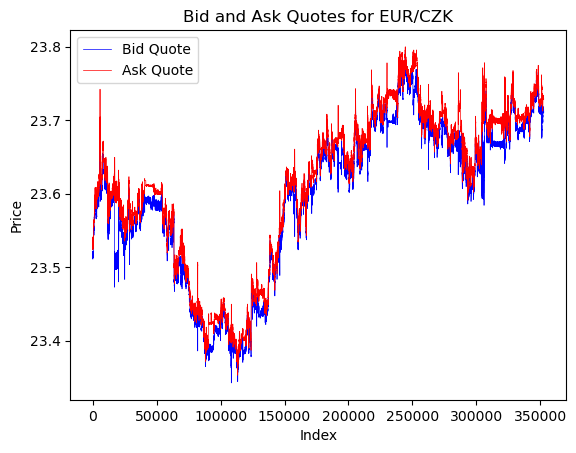

In [41]:
data = pd.read_csv("clean_DAT_ASCII_EURCZK_T_202305.csv")

# Extract column names
column_names = ['DateTime Stamp', 'Bid Quote', 'Ask Quote', 'Volume']

# Assign column names to the DataFrame
data.columns = column_names

# Calculate mid-price
p = pd.DataFrame({"Mid Price": (data['Bid Quote'] + data['Ask Quote']) / 2})

# Initialize ask quotes which we execute on:
p["Ask Quote"] = data["Ask Quote"]
p["Bid Quote"] = data["Bid Quote"]

# Plotting bids and asks as separate lines with thinner lines
plt.plot(p.index, p['Bid Quote'], label='Bid Quote', color='blue', linewidth=0.5)
plt.plot(p.index, p['Ask Quote'], label='Ask Quote', color='red', linewidth=0.5)

plt.xlabel("Index")
plt.ylabel("Price")
plt.title("Bid and Ask Quotes for EUR/CZK")
plt.legend()
plt.show()


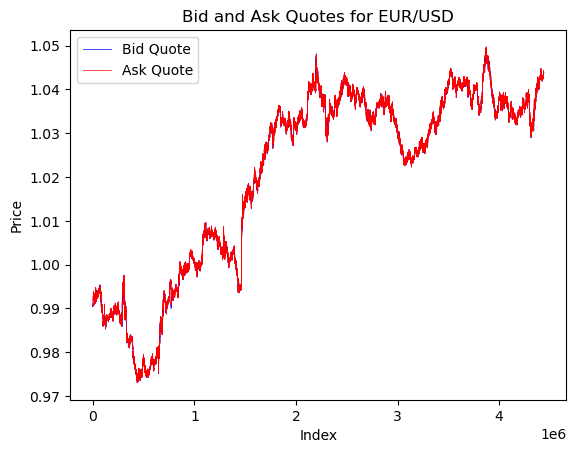

In [42]:
data = pd.read_csv("clean_DAT_ASCII_EURUSD_T_202211.csv")

# Extract column names
column_names = ['DateTime Stamp', 'Bid Quote', 'Ask Quote', 'Volume']

# Assign column names to the DataFrame
data.columns = column_names

# Calculate mid-price
p = pd.DataFrame({"Mid Price": (data['Bid Quote'] + data['Ask Quote']) / 2})

# Initialize ask quotes which we execute on:
p["Ask Quote"] = data["Ask Quote"]
p["Bid Quote"] = data["Bid Quote"]

# Plotting bids and asks as separate lines with thinner lines
plt.plot(p.index, p['Bid Quote'], label='Bid Quote', color='blue', linewidth=0.5)
plt.plot(p.index, p['Ask Quote'], label='Ask Quote', color='red', linewidth=0.5)

plt.xlabel("Index")
plt.ylabel("Price")
plt.title("Bid and Ask Quotes for EUR/USD")
plt.legend()
plt.show()

We see a hugely tighter bid-ask spread which is barely even noticable without zooming in, for the EUR/USD compared to EUR/CZK. This could have varied effects on the profit-loss, usually we would result in having less losses as the ask-price will generally be closer to the bid-price and subsequently mid-price which we use to find directional changes.

In some cases for EUR/CZK we see huge increases in the size of the spread, e.g. at index=320000. This can cause huge unexpected losses in profit-loss calculations increasing volatility in our profit-loss expectation in tests - One modification here could be to hold off on trading when spread is high.

### Proposing a further modification to "Lab 8 Modified":


1. Open long position at $DC↑(\theta)$ confirmation
2. (Take profit:) Close position at $P_C \geq P_{DCC}↑ \times (1+\theta)$
3. (Stop loss:) Close position at $P_C \leq P_{DCC}↓ \times (1-\frac{\theta}{2})$
4. Open short position at DC↓$(\theta)$ confirmation
5. (Take profit:) Close position at $P_C \leq P_{DCC}↓ \times (1-\theta)$
6. (Stop loss:) Close position at $P_C \geq P_{DCC}↑ \times (1+\frac{\theta}{2})$


Now our position in profitable situations is allowed to ride out further as we dont go $\frac{\theta}{2}$ into profit, from entry price, but now all the way to $\theta$ times entry price.

In theory this will allow our profitable trades to not close as early so that they can make more profit, however there is a chance that the price would swing back in the other direction and cause more stop losses to be triggered, i.e making more losses.

###### Code Below:

In [73]:
def go_longer_shorter(data, print_true=True, delta=0.003):
    # Extract column names
    column_names = ['DateTime Stamp', 'Bid Quote', 'Ask Quote', 'Volume']
    
    # Assign column names to the DataFrame
    data.columns = column_names
    
    # Mid-price
    p = pd.DataFrame({"Price": (data['Bid Quote'] + data['Ask Quote']) / 2})         

    # Initialise ask quotes which we execute on:
    p["Ask Quote"] = data["Ask Quote"]

    # Initialise variables for algo
    p["Event"] = ''

    run = "upward"       # initial run
    ph = p['Price'][0]   # highest price
    pl = ph              # lowest price
    pl_i = ph_i = 0
    d = delta

    # Define theta value for profit and stop-loss
    theta = d

    # Initialise variables for tracking positions and profit/loss
    position_open_long = False
    position_open_short = False
    entry_price = 0
    take_profit = 0
    stop_loss = 0
    profit_loss_list = []
    profit_loss_list_short = []

    # For graphing
    take_profit_positions = []
    stop_loss_positions = []
    take_profit_positions_short = []
    stop_loss_positions_short = []

    # Initialise lists to store positions opened
    position_open_long_t = []
    position_open_long_prices = []
    position_open_short_t = []
    position_open_short_prices = []

    # Slide 44 algorithm:
    for t in range(0, len(p)):
        pt = p["Price"][t]
        pt_ask = p["Ask Quote"][t]

        if run == "downward":
            if pt < pl:
                pl = pt
                pl_i = t

                # SHORTING
                if position_open_short:
                    if pt_ask <= take_profit_short or pt_ask >= stop_loss_short:
                        position_open_short = False
                        if pt_ask <= take_profit_short:
                            profit_loss = entry_price_short - pt_ask
                            take_profit_positions_short.append((t, pt_ask))
                        else:
                            profit_loss = entry_price_short - pt_ask
                            stop_loss_positions_short.append((t, pt_ask))
                        profit_loss_list_short.append(profit_loss)

            if pt >= pl * (1 + d):
                p.at[pl_i, 'Event'] = "start upturn event"
                run = "upward"
                ph = pt
                ph_i = t
                if not position_open_long:
                    entry_price = pt_ask
                    take_profit = entry_price * (1 + theta / 1)
                    stop_loss = entry_price * (1 - theta / 2)
                    position_open_long = True
                    position_open_long_t.append(t)
                    position_open_long_prices.append(pt_ask)

        elif run == "upward":
            if pt > ph:
                ph = pt
                ph_i = t

            if position_open_long:
                if pt_ask >= take_profit or pt_ask <= stop_loss:
                    position_open_long = False
                    if pt_ask >= take_profit:
                        profit_loss = pt_ask - entry_price
                        take_profit_positions.append((t, pt_ask))
                    else:
                        profit_loss = pt_ask - entry_price
                        stop_loss_positions.append((t, pt_ask))
                    profit_loss_list.append(profit_loss)

            if pt <= ph * (1 - d):
                p.at[ph_i, 'Event'] = "start downturn event"
                run = "downward"
                pl = pt
                pl_i = t

                # SHORTING
                if not position_open_short:
                    entry_price_short = pt_ask
                    take_profit_short = entry_price_short * (1 - theta / 1)
                    stop_loss_short = entry_price_short * (1 + theta / 2)
                    position_open_short = True
                    position_open_short_t.append(t)
                    position_open_short_prices.append(pt_ask)

    range_bottom = 1
    range_top = 4200000
    
    if print_true:
        
        # Plotting Price with Directional Change Events
        plt.plot(p.index[range_bottom:range_top+1], p['Price'].iloc[range_bottom:range_top+1], label='Price', linewidth=0.5)

        # Plot Take Profit and Stop Loss points --- Long
        take_profit_t, take_profit_prices = zip(*take_profit_positions)
        stop_loss_t, stop_loss_prices = zip(*stop_loss_positions)
        plt.scatter(take_profit_t, take_profit_prices, color='blue', marker='v', label='Take Profit')
        plt.scatter(stop_loss_t, stop_loss_prices, color='orange', label='Stop Loss')
        plt.scatter(position_open_long_t, position_open_long_prices, color='purple', marker='v', label='Position Open (Long)')

        # Plot Take Profit and Stop Loss points --- Short
        take_profit_t_short, take_profit_prices_short = zip(*take_profit_positions_short)
        stop_loss_t_short, stop_loss_prices_short = zip(*stop_loss_positions_short)
        plt.scatter(take_profit_t_short, take_profit_prices_short, color='black', marker='v', label='Take Profit (Short)')
        plt.scatter(stop_loss_t_short, stop_loss_prices_short, color='green', label='Stop Loss (Short)')
        plt.scatter(position_open_short_t, position_open_short_prices, color='red', marker='v', label='Position Open (Short)')

        plt.xlabel("Time")
        plt.ylabel("Price")
        plt.title("Executing strategy on DC event based time")
        plt.legend()
        plt.show()
    
    # Calculate final profit/loss
    final_profit_loss = sum(profit_loss_list + profit_loss_list_short)
    print("Final Profit/Loss:", final_profit_loss)
    

In [74]:
# EURUSD 2020 September
data = pd.read_csv("clean_DAT_ASCII_EURUSD_T_202009.csv")

# Define a set of deltas to test
deltas_to_test = [0.0025, 0.0030, 0.0035, 0.004]

# Dictionary to store results
results = {}

# Run the strategy for each delta and store the results
for delta in deltas_to_test:
    
    print(f"Delta: {delta}", " Corresponding profit/loss below:")
    test(data, print_true=False, delta=delta)

Delta: 0.0025  Corresponding profit/loss below:
Final Profit/Loss: 0.013550000000000173
Delta: 0.003  Corresponding profit/loss below:
Final Profit/Loss: 0.005769999999999165
Delta: 0.0035  Corresponding profit/loss below:
Final Profit/Loss: 0.016859999999998987
Delta: 0.004  Corresponding profit/loss below:
Final Profit/Loss: 0.020710000000000672


This strategy however performs very similarly in the case of EURUSD 2020 September, in some cases the profit is higher and others lower. But this is was expected as a profitable trade will potentially make double the money as before, but has to ride out for longer to hit that take profit. 

Perhaps this could be used in the following way:

###### If you expect market to rise: Have only the long position go further:
1. Open long position at $DC↑(\theta)$ confirmation
2. (Take profit:) Close position at $P_C \geq P_{DCC}↑ \times (1+\theta)$
3. (Stop loss:) Close position at $P_C \leq P_{DCC}↓ \times (1-\frac{\theta}{2})$
4. Open short position at DC↓$(\theta)$ confirmation
5. (Take profit:) Close position at $P_C \leq P_{DCC}↓ \times (1-\frac{\theta}{2})$
6. (Stop loss:) Close position at $P_C \geq P_{DCC}↑ \times (1+\frac{\theta}{2})$
        
###### If you expect market to fall: Have only the short position go further:
    
1. Open long position at $DC↑(\theta)$ confirmation
2. (Take profit:) Close position at $P_C \geq P_{DCC}↑ \times (1+\frac{\theta}{2})$
3. (Stop loss:) Close position at $P_C \leq P_{DCC}↓ \times (1-\frac{\theta}{2})$
4. Open short position at DC↓$(\theta)$ confirmation
5. (Take profit:) Close position at $P_C \leq P_{DCC}↓ \times (1-\theta)$
6. (Stop loss:) Close position at $P_C \geq P_{DCC}↑ \times (1+\frac{\theta}{2})$

This could be backtested on data where the market is rising or falling for the respective scenarios; it is perhaps is easier to predict bull/bearish markets and have these strategies for them.

# Conclusion

We began by dissecting high-frequency tick data into Directional Change Intrinsic Time by use of the algorithm we saw in class, and then we performed some cleaning of the data with the use of the file_status_report files that accompany each download of the data. While testing in my IDE, I didn't notice a big difference in the directional change points or profit-loss before or after cleaning, perhaps the gaps we got rid off were just insignificant.

Then in Chapters 1.3 and 1.4 we implemented the Lab 8 strategy as well as Lab 8 Modified, it was an interesting choice to also try taking a short position in the exact same way but for the opposite direction. We compare the results and then take a look at the bid-ask spread as it is larger in less traded currency pairs which can have an effect on profit-loss.

We finally propose a new strategy and have an idea that it could work for certain scenarios, obviously if used in real-time, you won't know if the market will go up or down, but maybe some traders have a better inclination or with the use of some statistics/news/intuition.




## References

[1] - Carmine Ventre,(2024)High-Frequency Finance, l-08-events-handouts, Slide 44